# PHYS 481 Assignment 5
October 8, 2019

## Authors: 
Siegfried Peschke (30032136) \\
Matthew Bouchard (30003689) \\
Chris Godek (30030527)

### Importing Necessary Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scipy

## Question 1

**Problem:** Write a Python code to explicitly follow the evolution of two interacting random walkers on a line (1D lattice), i.e. by direct simulation, not by using the transfer matrix approach. Have both walkers start at the same point, the midpoint of the lattice. Consider $\lambda=0$, $\frac{1}{3}$, $\frac{2}{3}$, and $1$. Repeat many times to obtain a distribution function. Comment on the results and compare (statistically) with the those for non-interacting walkers. Repeat the calculations for initial conditions where the two walkers start off adjacent to one another, and compare.

### Two Independant Walkers

To start, allow us to consider the more simplistic case of non-interacting random walkers. That is, we have two independant walkers being located on the same lattice. They can cross over each other and be on the same lattice site without any additional considerations - that is, the movements of one walker do not affect the movements of another. The reason we wish to do this is get a better grasp of what is going on with the problem.

To start we will define a function that will move two independant walkers randomy:

In [0]:
def independant_random_walker(Nsteps):
  
  """
  
  -- How it Works --
  
  The purpose of this function is to determine the location of two independant walkers.
  This means that there will be two walkers on the same 1D grid, but their interactions
  will be distinct from one another - i.e the movement/position of one walker will NOT 
  affect the other. As such, this function keeps track of the "random" position of two
  random walkers. The function will output the location of the first walker [0], the location 
  of the second walker [1] and the difference between their stepping site [2].
  
  -- Arguments --
  
  Nsteps = The number of steps that each walker will be taking
  
  """
  
  location1 = 0 # The starting location for the first random walker
  location2 = 0 # The starting location for the second random walker
  
  movement1 = np.random.randint(0,2,Nsteps) # we need to calculate the probability of steping seperately
  movement2 = np.random.randint(0,2,Nsteps) # because the walkers are independant of one another
  
  for i in range(Nsteps): # Taking nsteps for both walkers
    
    # -- Acessing the Random Values Stored for Each Step --
    
    move1 = movement1[i] 
    move2 = movement2[i]
    
    # -- First Walker --
    if move1 == 0:
      location1 -= 1
     
    if move1 == 1:
      location1 +=1
      
    # -- Second Walker --
    if move2 == 0:
      location2 -= 1
     
    if move2 == 1:
      location2 +=1
      
  return [ location1, location2 , location1-location2 ]

In [0]:
# checking to see if the function retunrns intended results
independant_random_walker(100)

[8, -8, 16]

Now that we a function that walks for our two random walkers, we want to create a function that will perform this many times (i.e for a large number of trial runs). In doing this we can obtain a probability distribution that dictates what the average seperation distance between the two walkers will be. We only want to consider their seperation distance as in the future this is what will be affecting the results (i.e walkers closer to one another may or may not have a propensity to interact). 

In [0]:
def independant_walker_trials( Nsteps , Ntrials ):
  
  """
  
  -- How it Works --
  
  The purpose of this function is to record the seperation distance between two independant
  random walkers over many trial runs. Each trial run is independant and walkers will be
  returned to their starting positions (0) after each run. The seperation distances will
  be returned in a list upon running the function.
  
  -- Arguments --
  
  Nsteps = The number of steps you wish both walkers to take
  Ntrials = The number of times you wish the walkers to take random steps
  
  """
  
  seperation_list = [] # Seperation values stored in this list
  
  for i in range(Ntrials): # Performing N trials 
    final_seperation = independant_random_walker(Nsteps)[2] # Only want seperation distances
    seperation_list.append(final_seperation) # Storing final seperation values
    
  return seperation_list

In [0]:
# Checking to see if the trial function works:
independant_walker_trials( 100 , 5 )

[-16, 12, 22, -14, -4]

And finally, allow us to create a function that will return the probabilities of landing in a particular location. This function is necessary for us to plot a probability distribution.

In [0]:
def walker_probabilities( Nsteps , Ntrials ):
  
  """
  
  -- How it Works --
  
  
  -- Arguments --
 
  Nsteps = The number of steps you wish both walkers to take
  Ntrials = The number of times you wish the walkers to take random steps
  
  """
  
  seperation = independant_walker_trials ( Nsteps , Ntrials)
  
  seperation_list = np.unique( seperation , return_counts = True )[0]
  occurance_list = np.unique( seperation , return_counts = True )[1]
  
  return seperation_list , occurance_list/Ntrials

Now, allow us to plot some probabilities based on the seperation distance between walkers. Let us try 500 steps over 100000 trials!

In [0]:
# Storing data for plotting purposes
location , probability = walker_probabilities( 500 , 100000 )

<BarContainer object of 130 artists>

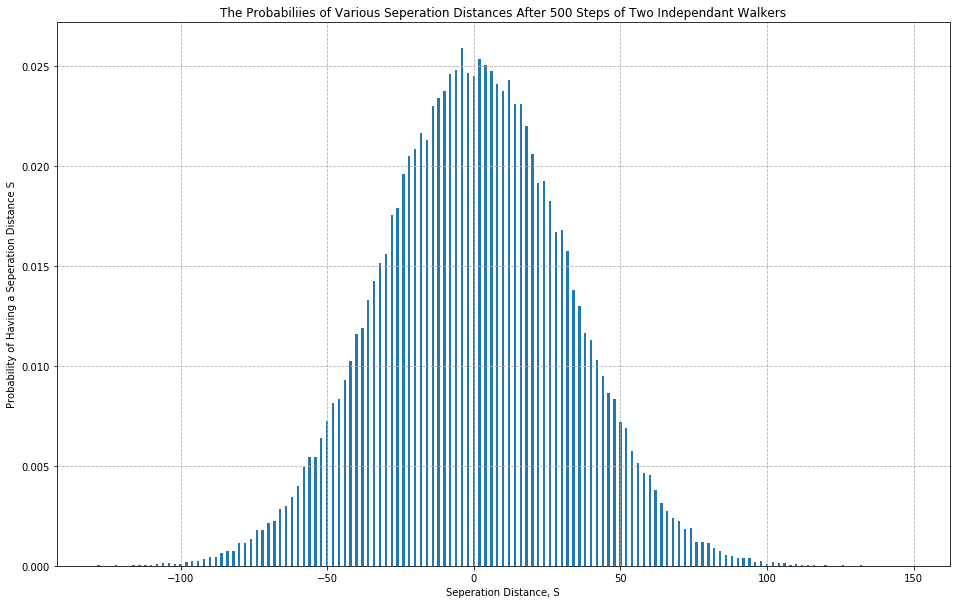

In [0]:
# Plotting Labels
plt.figure(figsize=(16,10))
plt.xlabel('Seperation Distance, S')
plt.ylabel('Probability of Having a Seperation Distance S')
plt.title('The Probabiliies of Various Seperation Distances After 500 Steps of Two Independant Walkers')
plt.grid(linestyle='dashed')

#Plotting Values and Associated Trendline
plt.bar( location, probability )# Plotting values of N against r in a scatter plot

As expected, we have a gaussian distribution of where the two walkers may be relative to one another. More often than not they will eithe be superimposed on one another (i.e same spot) or very nearby(i.e $\pm 4$ locations). This is expected because in the previous assignment we showed that random walkers are most likely to land at the center of the lattice (i.e their initial starting position).

### Two Interacting Walkers

Now we want to move into the situation where we are considering interactions between the two walkers. When the two walkers have a seperation distance greater than two they are free to move in whatever fashion they like (this will be the exact same as the state above). However, we are now in a case that when the particles are adjacent (i.e a seperation distance of 2) they have varying probabilities of how they will interact. We can account for varying probabilities of events occuring by accounting for the conditions in a "interaction" function.

Before we consider the interaction scenario allow us to define two functions: (1) will perform a random movement for each walker if they are not adjacent and (2) will take into account the probabilities of interaction if the two walkers are adjacent.

In [0]:
def move_walker( pos1 , pos2 ):
  
  """
  
  -- How it Works -- 
  
  This function will generate a random integer corresponding to the "drunken walk".
  The random number will be correlated to a movement left or right, and the output
  will shift the walkers position by a SINGLE unit.
  
  -- Arguments --
  
  pos = The position of the walker
  
  """
  
  move1 = np.random.randint(0,2) # Generate random move for first walker
  move2 = np.random.randint(0,2) # Generate random move for second walker
  
  # -- First Walker --
  if move1 == 0: # Move right
    pos1 -= 1
  elif move1: # Move right
    pos1 += 1
    
  # -- Second Walker --
  if move2 == 0: # Move right
    pos2 -= 1
  elif move2: # Move right
    pos2 += 1
    
  return pos1, pos2

In [0]:
def gen_collision(lam, pos1, pos2):
  
  """
  
  -- How it Works --
  
  This function will be used to move the walkers in the case that the seperation distance between
  them is 2 and a collision is possible. This function will move the walkers in 4 cases (1) to
  hit each other, (2) to both move right, (3) to both move left and (4) the walkers move apart.
  The probability of each of these will be dictated by a the lam value - and a 'random one'
  
  pos1 must be greater than pos2 i.e. pos1 is the walker on the right
  
  -- Arguments --
  
  lam = The lamda value that will dicate the probability that a specific event will occur
  pos1 = The position of the first walker (should be the larger value for conditions 1 and 4)
  pos2 = The position of the second walker (should be the smaller value for conditions 1 and 4)
  
  """
  
  r = np.random.random() # Creating a random value between 1 and 0
  
  if (r < lam/4): #Walkers hit each other and bounce off
    pos1 += 1
    pos2 -= 1
    
  elif (r >= lam/4 and r < lam/4+(1-lam/4)/3): #Walkers both move right
    pos1 += 1
    pos2 += 1
    
  elif (r >= lam/4+(1-lam/4)/3 and r < lam/4+2*(1-lam/4)/3): #Walkers both move left
    pos1 -= 1
    pos2 -= 1
    
  elif (r >= lam/4+2*(1-lam/4)/3 and r < 1): #Walkers move apart
    pos1 += 1
    pos2 -= 1
  
  return pos1, pos2

Now that we have defined the two conditions that the walkers may be under (1) independant and (2) interacting; we can use these to create a walking scenario. That is, we will let the walkers move about randomly and where they land will be dicated by probability. As such, allow us to define a walking function: 

In [0]:
def interacting_walkers(pos1, pos2, steps, lam):
  
  """
  
  -- How it Works --
  
  This function will perform the walks taken for two interacting walkers. If the walkers are
  seperated by a distance greater than 1 or 2 then they will act as if they are independant from one
  another. If there seperation distance is equivalent to 1 or 2 they will act under the probabilities
  dictated in the previous function. This function will then return the final locations of both 
  walkers and their seperation distance.
  
  -- Arguments --
  
  pos1 = The position of the first walker (larger)
  pos2 = The position of the second walker (smaller)
  steps = The number of steps that will be taken
  lam = The probability value that will dicate the interactions between particles
  
  """
  
  for m in range(steps):
    if (abs(pos1-pos2) == 1):
      
      if pos1 >= pos2:
        pos1, pos2 = gen_collision(lam, pos1, pos2)
      else:
        pos2, pos1 = gen_collision(lam, pos2, pos1)
        
    elif (abs(pos1-pos2) == 2):
      
      if pos1 >= pos2:
        pos1, pos2 = gen_collision(lam, pos1, pos2)
      else:
        pos2, pos1 = gen_collision(lam, pos2, pos1)
        
    else:
      pos1 , pos2 = move_walker( pos1 , pos2 )
  
  return pos1, pos2

And finally, we must create a function for which we can perform multiple trial runs. This will be useful so that we can perform a graphical analysis of the statiscs afterwards.

In [0]:
def many_walkers(pos1, pos2, steps, lam, N_trials):
  
  """
  
  -- How it Works --
  
  This function will perform multiple walks to return statistics on the final seperation
  distances of the walkers. After each trial the position of the walkers will be returned
  to 0 and we will restart the trial. The final output will be seperation list and occurance lists
  which will contain the probability of landing in a particular region
  
  -- Arguments --
  
  pos1 = The position of the first walker (larger)
  pos2 = The position of the second walker (smaller)
  steps = The number of steps that will be taken
  lam = The probability value that will dicate the interactions between particles
  N_trials = The number of trials we will run the random walkers
  
  """
  
  seperation_list = [] # A list containing 
  
  for i in range(N_trials): # Performing N trials to retrieve statistics
    w1, w2 = interacting_walkers(pos1, pos2, steps, lam)
    seperation_list.append(w1-w2)

  sep_list, occ_list = np.unique(seperation_list, return_counts = True)
  occ_list = occ_list / N_trials # Determining the probability of landing in a particular location
  
  return sep_list, occ_list

And finally, plotting these values we find that:

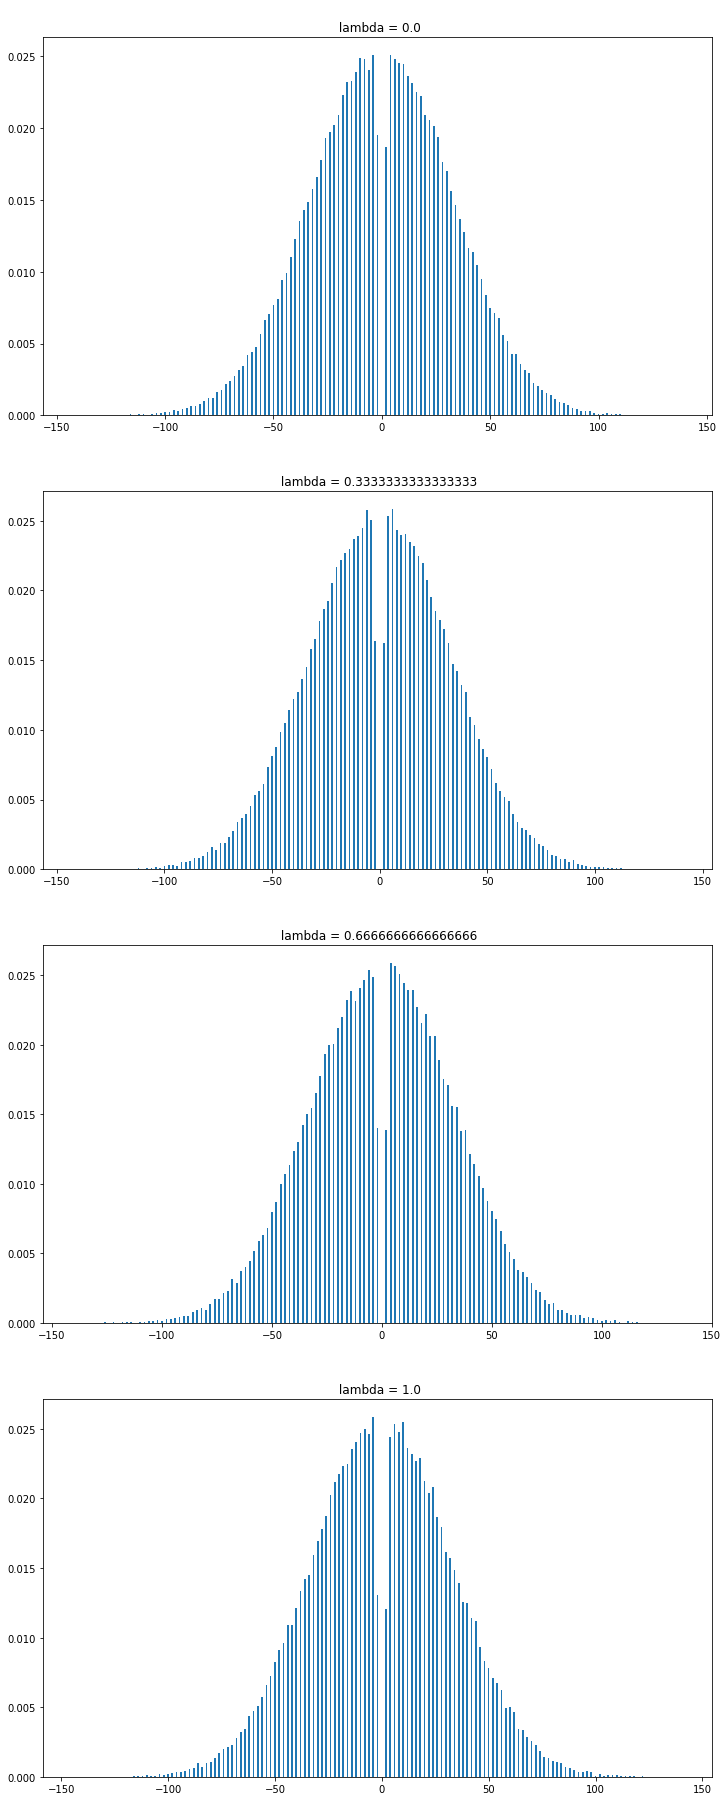

In [0]:
pos1 = 0
pos2 = 0
steps = 500
N_trials = 100000
lam_list = [0.0, 1/3, 2/3, 1.0]

#Ploting the Functions
fig, axs = plt.subplots(4,1, figsize=(12,32))

for a in range(len(lam_list)):
  sep_list, occ_list = many_walkers(pos1, pos2, steps, lam_list[a], N_trials)
  plot_name = '\n lambda = ' + str(lam_list[a])
  axs[a].bar(sep_list, occ_list)
  axs[a].set_title(plot_name)

The results that were found here were to be expected. for a $\lambda=1$ we have completely non-interacting particles, which means we would expect a Gaussian distribution, as we have seen. In the case of $\lambda=0$ we are in the completely opposite regime and we expect the particles to be completely repelled by one another (indicating they would never be in the exact same spot, or rather, the centre value where they start). As such, there is no chance that the particles will be located at the centre (apart from the initial setup), which is exactly what we see here.

Now, the case plotted above was when the random walkers started on the same location. the second instance that we wish to plot is if the two walkers start of adjacent to one another; that is say a walker starts in position [0] while the other starts in position [1]. Plotting this, we find the following:

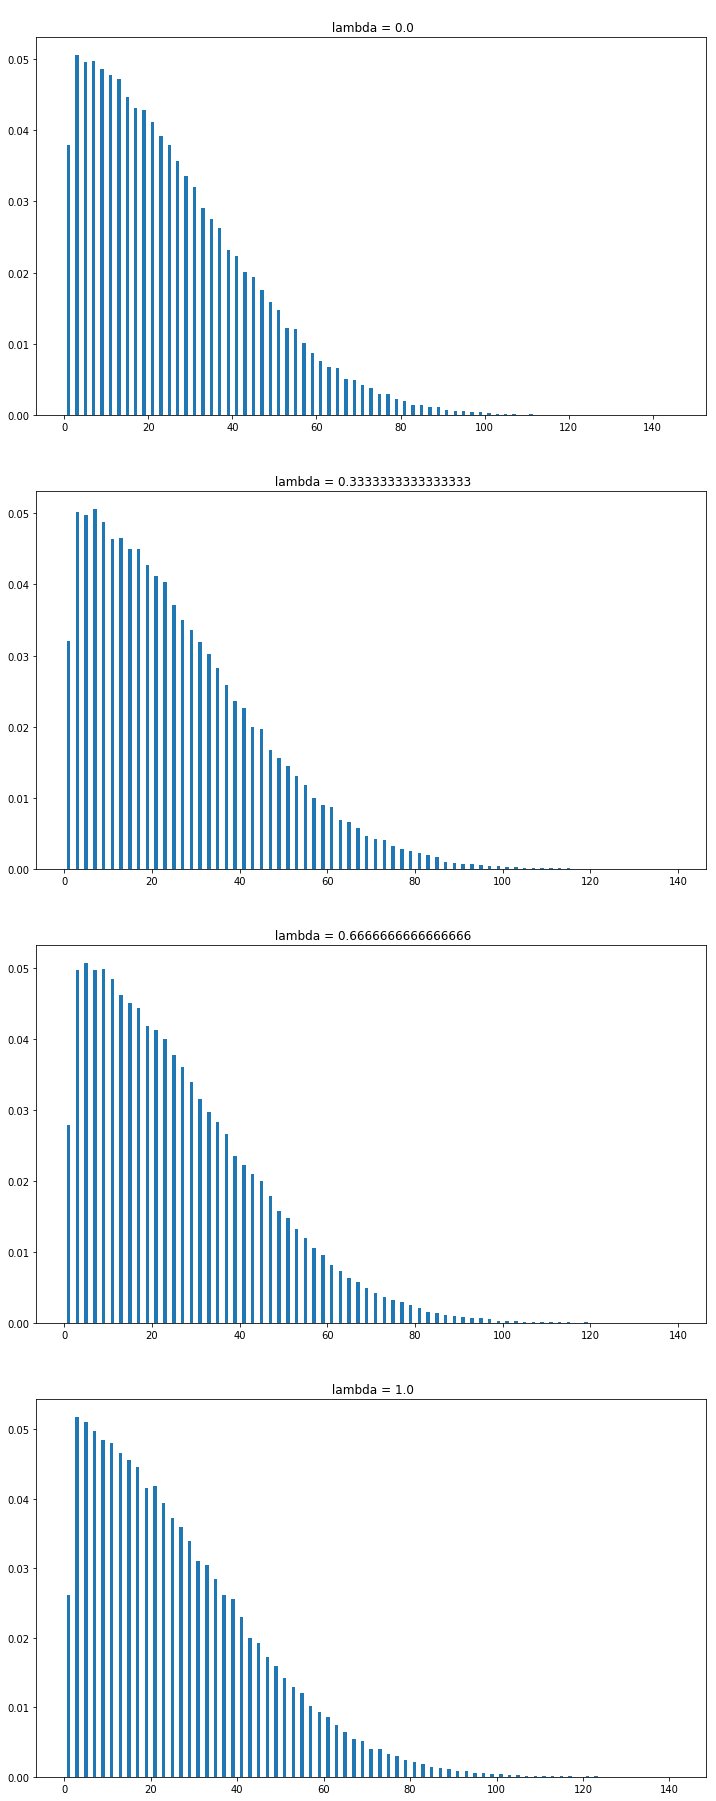

In [0]:
# Defining the Parameters we wish to run over
pos1 = 1 # As position 1 should be our larger value
pos2 = 0
steps = 500
N_trials = 100000
lam_list = [0.0, 1/3, 2/3, 1.0]

#Ploting the Functions
fig, axs = plt.subplots(4,1, figsize=(12,32))

for a in range(len(lam_list)):
  sep_list, occ_list = many_walkers(pos1, pos2, steps, lam_list[a], N_trials)
  plot_name = '\n lambda = ' + str(lam_list[a])
  axs[a].bar(sep_list, occ_list)
  axs[a].set_title(plot_name)

## Question 2

One important quantity in simulations of networks in computer science and physics is the *hitting time* $h$. This is the average number of steps (i.e. time) needed for a random walker (starting in a random position $r$) to occupy some other (randomly chosen) site $s$ of the network. Quantities of interest include: the characteristics of the distribution of hitting times as a function of the distance between $r$ and $s$, where distance is measured as the minimum number of hops required to get from $s$ to $r$ (or vice versa); and the mean hitting time as a function of the network diameter, where the diameter is the smallest number of hops required to get from any site to any other. For a one-dimensional line, the diameter is simply the number of sites $N$.

###Part 1:

**Problem (20 points):** Consider a single random walker on a one-dimensional line with $N$ sites, with periodic boundary conditions (i.e. a circle); please use real randomness, not the Markov chain. For $N=20$, obtain the distribution of hitting times for the case when $r$ and $s$ are as far apart as possible. Obtain the mean hitting time and the standard deviation. Obtain the asymptotic behaviour of the distribution function (i.e. for long times).

To start, allow us to define a function that will determine the amount of time it requires a walker to reach the site s (which is the furthest point from the walkers starting position 0). The furthest point from 0 in our chain of length 20 (with periodic boundary conditions) would be 10, or written in terms of lists, [9]. We will manipulate the first function we have defined to do this:

In [0]:
def timer(stop_point):
  
  """
  
  -- How it Works --
  
  This function has a walker move randomly over a size N=20 dimensional grid. The walker
  has periodic boundary conditons, meaning that if we wants to move left at spot zero
  he will be returned to the othe end of the grid (N=19). This funciton measures how long
  it takes for the walker to reach a stopping point, with each time step being equivalent 
  to each step that he has taken. This function will then return the number of steps taken
  to reach the stopping point once it has been reached.
  
  -- Arguments --
  
  stop_point = Where you want the stop point to be
  
  """
  
  stopping_point = stop_point
  walker = 0
  step_counter = 0
  
  # -- Taking Steps with The Walker --
  
  while walker != stopping_point:
    
    direction = np.random.randint(0,2)
    
    # -- Placing Periodic Boundary Conditions on the Walker -- 
    
    if direction == 0 and walker == 0: # If the walker is at the start of the array and
      walker = 19                      # wishes to move LEFT
    
    elif direction == 1 and walker == 19: # If the walker is at the end of the array and
      walker = 0                          # wishes to move RIGHT
    
    # -- Performing Normal Walks if Not at Edge of Array --
    
    else:
      if direction == 0:
        walker -= 1
      if direction == 1:
        walker+= 1
  
    step_counter += 1
    
    if walker == stopping_point:
      #print("We reached S!")
      return step_counter
      break

Allow us to check that the function works quickly:

In [0]:
# How many steps does it take to reach our point of interest?
timer(9)

157

Now, we will create a function necessary to retrieve statistics based on many trials of walkers:

In [0]:
def multi_timer( Ntrials , stop_point ):
  
  """
  
  -- How it Works --
  
  This function returns statistics based on the periodic boundary conditions with a 
  stopping site. It will return the various stopping times, the unique stoping times and 
  how often the unique stoping times occured.
  
  -- Arguments --
  
  Ntrials = The number of trials you wish to run
  stop_point = The stopping point of the walker
  
  """
  
  # -- Creating a List of Stopping Times after Ntrials --
  stopping_times = []
  
  for trial in range(Ntrials):
    stopping_time = timer(stop_point)
    stopping_times.append(stopping_time)
    
  #  -- Returning Statistics on Stopping Times --
  
  unique_stops = np.unique( stopping_times , return_counts = True )[0]
  unique_occurances = np.unique( stopping_times , return_counts = True )[1]
  
  return stopping_times , unique_stops , unique_occurances

And finally, allow us to plot the final values:

In [0]:
stops , unique_stops, unique_occurances = multi_timer(100000,9)

<BarContainer object of 341 artists>

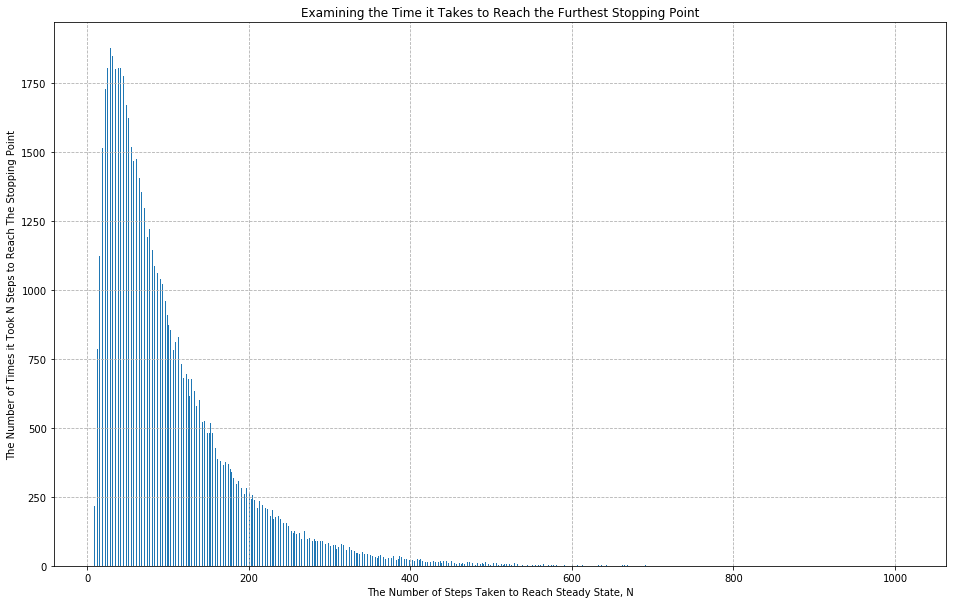

In [0]:
# Plotting Labels
plt.figure(figsize=(16,10))
plt.xlabel('The Number of Steps Taken to Reach Steady State, N')
plt.ylabel('The Number of Times it Took N Steps to Reach The Stopping Point')
plt.title('Examining the Time it Takes to Reach the Furthest Stopping Point')
plt.grid(linestyle='dashed')
#plt.xlim(35,1000)

#plt.xscale('log')
#plt.yscale('log')

#Plotting Values and Associated Trendline
plt.bar( unique_stops, unique_occurances )# Plotting values of N against r in a scatter plot

And now we can calculate the mean of the numer of steps required and the standard deviation:

In [0]:
mean = np.mean(stops)
deviation = np.std(stops)
print('The mean number of steps required to for r = s is:', round(mean,3) )
print('The standard deviation is given by:', round(deviation,3) )

The mean number of steps required to for r = s is: 98.975
The standard deviation is given by: 81.272


Now, to obtain the asymtotic behaviour of this curve we want to detemine how it decays. Notice how for the first few entries appear to be "fuzzy", i.e the data it increasing at intervals with no discernable pattern. Following the peak, it decays in a nice fashion towards zero. To determine how the system decays allow us to remove the "fuzziness" and fit the remaining data. I also removed the end of the plots 

In [0]:
unique_stops_adjusted = unique_stops[35:-100]
unique_occurances_adjusted = unique_occurances[35:-100]

Fitting the data to a power law (as we know the data is liner if in a log-linear plot) will allow us to determine its scaling. To start, lets see what happens if we log the y-axis.

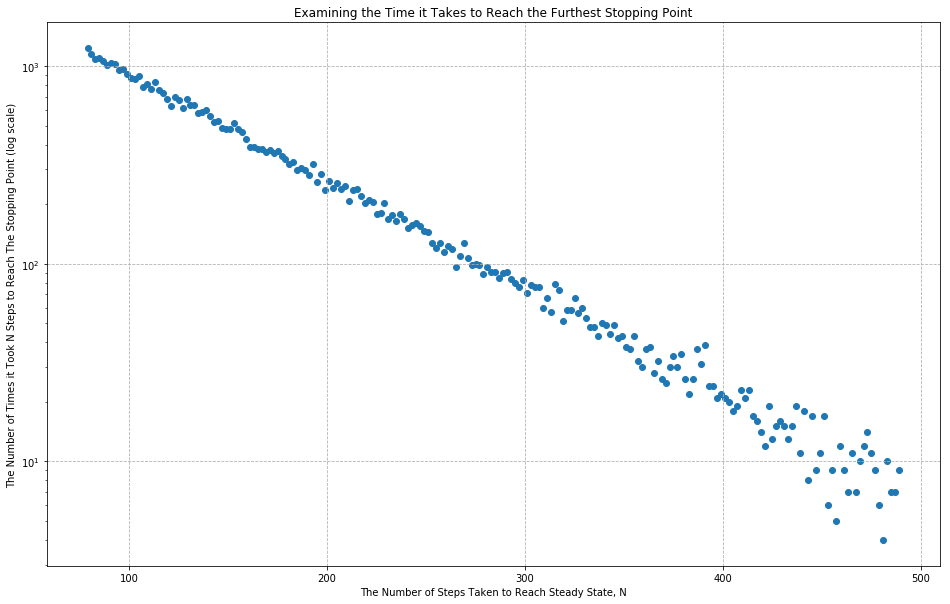

In [0]:
# Plotting Labels
plt.figure(figsize=(16,10))
plt.xlabel('The Number of Steps Taken to Reach Steady State, N')
plt.ylabel('The Number of Times it Took N Steps to Reach The Stopping Point (log scale)')
plt.title('Examining the Time it Takes to Reach the Furthest Stopping Point')
plt.grid(linestyle='dashed')

plt.yscale('log')

# log-linear = Exponential decay/growth
# log-log = Power law decay/growth

#Plotting Values and Associated Trendline
plt.scatter( unique_stops_adjusted , unique_occurances_adjusted ) # Plotting values of N against r in a scatter plot

We retrieve a linear slope if we ONLY log the y-scale. This indicates that we have an associated power law. As such, allow us to attempt to fit the data.

In [0]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress( unique_stops_adjusted , np.log10(unique_occurances_adjusted) )

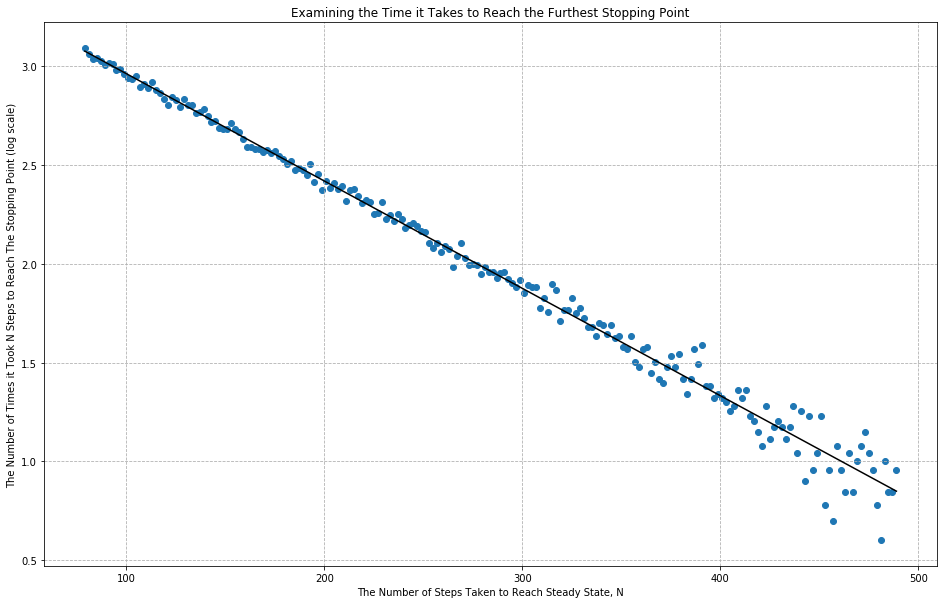

In [0]:
# Plotting Labels
plt.figure(figsize=(16,10))
plt.xlabel('The Number of Steps Taken to Reach Steady State, N')
plt.ylabel('The Number of Times it Took N Steps to Reach The Stopping Point (log scale)')
plt.title('Examining the Time it Takes to Reach the Furthest Stopping Point')
plt.grid(linestyle='dashed')

#plt.yscale('log')

# log-linear = Exponential decay/growth
# log-log = Power law decay/growth

#Plotting Values and Associated Trendline
plt.scatter( unique_stops_adjusted , np.log10(unique_occurances_adjusted) ) # Plotting values of N against r in a scatter plot
plt.plot( unique_stops_adjusted , slope*unique_stops_adjusted + intercept , color='black')

Which returns a slope and intercept of the following values:

In [0]:
print('The slope in linear-log scaling is:',slope)
print('The intecept in linear-log scaling is:' , intercept)

The slope in linear-log scaling is: -0.005430112685527516
The intecept in linear-log scaling is: 3.504429693917884


Now, the trend line we have derived is described by the following equation:

$$ y = Ae^{Bx}$$

Where $B$ is the slope of the line, and A is the log of our intecept:

$$ log(y) = log(A) + Bx$$

Without caring about the scalling we can say that the the trend scales as:

$$ y \sim e^{-0.0054x} $$

Or in other words, that the probability of reaching the furthest stopping point scales as a decreasing exponential, or a decay curve. That is, if we ignore the "fuzziness" at the beginning of the data set you are more likely to reach the furthest stopping points in a fewer number of steps (~100) as opposed to a large value (> 400).

### Part 2:

**Problem (10 points):** Plot the mean hitting time $\overline{h}$ as a function of the separation $|s-r|$ and obtain its scaling. Comment on the results.

For this question allow us to further manipulate the functions we have defined above so that we can obtain the mean number of steps required to reach the stopping point for a range of stopping points between (1-10). We ignore the first point since we always start there, and we will only head to point 10 (i.e midway through the 1D lattice) because we have periodic boundary conditions.

In [0]:
def average_stopper(Ntrials):
  
  """
  
  -- How it works --
  
  This function will determine the average time it takes for the walker to reach a stopping
  point at a distance |s-r|. It will do this by calculating the mean stopping time over Ntrials
  for a seperation distance (|s-r|) of 1. It will then do the same for 2,3,4 and so on until a 
  maximum value of 9. The function will output the seperation list (i. 1,2,3,...,9) and the 
  mean stopping time over Ntrials.
  
  -- Arguments --
  
  Ntrials = The number of trials for which we would like to average the stopping time
  
  """

  average_list = []
  seperation_list = []
  
  for stop in range(1,10): # Running through the various stopping sites
    timing_list = [] # Storing values to calculate an average for each |s-r|
    seperation_list.append(stop)
    for trial in range(Ntrials): # Running multiple trials to retrieve the proper statistics
      time = timer(stop) # Timing the trial
      timing_list.append(time)

    average = np.mean(timing_list)
    average_list.append(average)

  return seperation_list , average_list

Finally, allow us to plot the mean stopping time as a function of the seperation distance.

In [0]:
# Storing Values for plotting
sep , avg = average_stopper(10000)

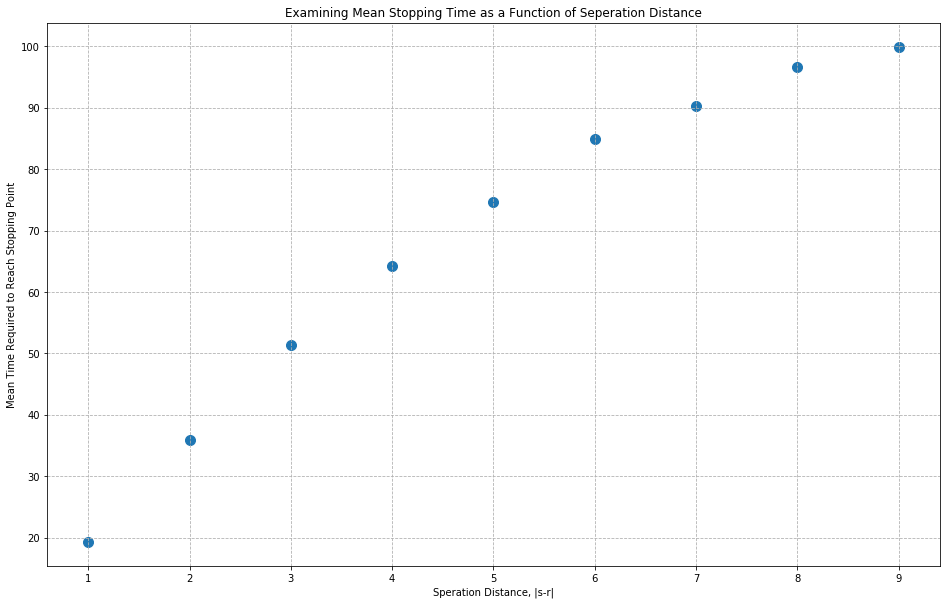

In [0]:
# Plotting Labels
plt.figure(figsize=(16,10))
plt.xlabel('Speration Distance, |s-r|')
plt.ylabel('Mean Time Required to Reach Stopping Point')
plt.title('Examining Mean Stopping Time as a Function of Seperation Distance')
plt.grid(linestyle='dashed')

#Plotting Values and Associated Trendline
plt.scatter( sep , avg , s=100 ) # Plotting values of N against r in a scatter plot

As such, for a N=20 1D grid we see that as the seperation distance increases the mean number of times required to reach that point steadily increases. It eventually reaches an asymtote at approximately 100 steps - where prior to that point the trend is relatively linear.